In [1]:
import os
import django
from django.db import connection
import sys
import datetime
sys.path.append('../')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'activity_viewer.settings')
django.setup()

In [2]:
from dashboard.models import Log, Item
from django.db.models import F, Count

In [3]:
%%time
download_requests = Log.objects.filter(http_status=200)
# Following must be evaluated to list so that s3_key__in works properly on the next line
# It finds the keys that have been most uniquely downloaded by IP address (not total)
file_keys = list(Log.objects
             .values_list('s3_key', flat=True)
             .annotate(count=Count('ip_address', distinct=True))
             .order_by('-count')[:16])
# Find all the IPs that could have downloaded at least one of the IPs in the list
# This narrows our search down tremendously and saves a lot of database search time
valid_ips = Log.objects.values_list('ip_address', flat=True).filter(s3_key__in=file_keys).distinct()

CPU times: user 17.6 ms, sys: 1.04 ms, total: 18.7 ms
Wall time: 7min 15s


In [4]:
print(connection.queries)

[{'sql': 'SELECT "dashboard_log"."s3_key", COUNT(DISTINCT "dashboard_log"."ip_address") AS "count" FROM "dashboard_log" GROUP BY "dashboard_log"."s3_key" ORDER BY "count" DESC  LIMIT 16', 'time': '435.141'}]


In [5]:
# This basically creates a matrix with the same list of keys for rows and columns
# The intersection of a row and a column signifies how many times these two files were downloaded together
df = pd.DataFrame(0, index=file_keys, columns=file_keys)

In [6]:
%%time
for ip in valid_ips:
    downloaded = Log.objects.values_list('s3_key', flat=True).filter(s3_key__in=file_keys, ip_address=ip).distinct()
    # Iterate over each unique pair of keys in the list that was downloaded from this specific IP
    for (key_1, key_2) in itertools.combinations(downloaded, 2):
        try:
            df.at[key_1, key_2] += 1
        except KeyError:
            pass

CPU times: user 710 ms, sys: 39.2 ms, total: 749 ms
Wall time: 6.13 s


In [7]:
# Finds index and column of the maximum value in the array, which may be of interest
# Axis 0 and 1 mean search for column and then row. For some reason you can not get the index and column
# with a single request, at least to my knowledge
key_1 = df.max(axis=0).idxmax().split('/')[-1]
key_2 = df.max(axis=1).idxmax().split('/')[-1]
max_value = df.values.max()
print(f'Most Downloaded Together Count: {max_value}, pair {key_1} and {key_2}')

Most Downloaded Together Count: 221, pair ENCFF945YRD.bed.gz and ENCFF854NXI.bed.gz


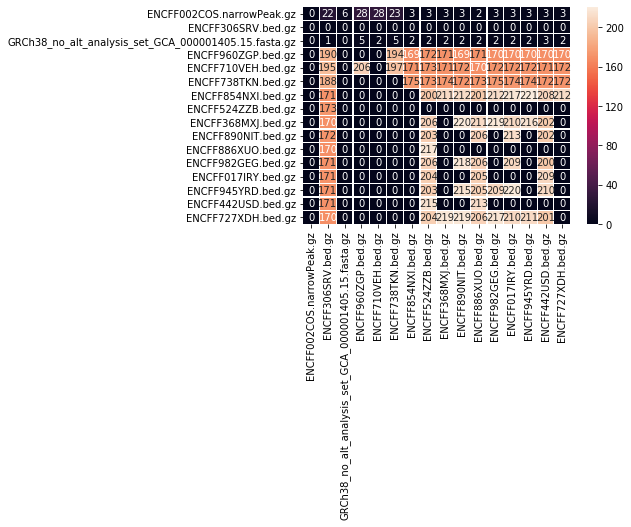

In [8]:
# Remove the long first part of the S3 key and only take the item name and file extension
truncated_labels = [item.split('/')[-1] for item in file_keys]
# fmt of empty prevents scientific notation which looks silly
axes = sns.heatmap(df, annot=True, fmt='', linewidths=0.1, xticklabels=truncated_labels, yticklabels=truncated_labels)